### Import Libraries

In [1]:
import os
import copy
import shutil
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import datasets,transforms 
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
file_ext = "png"
clf_result = "normal"
dataset_dir = "DatasetCombined"

In [ ]:
!wget http://openi.nlm.nih.gov/imgs/collections/NLM-MontgomeryCXRSet.zip
!unzip NLM-MontgomeryCXRSet.zip
!wget http://openi.nlm.nih.gov/imgs/collections/ChinaSet_AllFiles.zip
!unzip ChinaSet_AllFiles.zip

In [2]:
#Once the datasets are downloaded and unzipped, they'll be unpacked by default into folders named as defined below.

chinaset_img_path = "ChinaSet_AllFiles/CXR_png/"
chinaset_lbl_path = "ChinaSet_AllFiles/ClinicalReadings/"
montset_img_path = "MontgomerySet/CXR_png/"
montset_lbl_path = "MontgomerySet/ClinicalReadings/"
dest_path_normal = "DatasetCombined/Normal/"
dest_path_tb = "DatasetCombined/Tuberculosis/"

In [3]:
lbl_directories = [chinaset_lbl_path, montset_lbl_path ]
img_directories = [chinaset_img_path, montset_img_path ]

In [5]:
for i in range(len(lbl_directories)):
    for file in os.listdir(lbl_directories[i]):
        imgname = file[:-len(file_ext)] + file_ext
        with open(os.path.join(lbl_directories[i],file)) as report:
            for line in report:
                if clf_result in line:
                    shutil.copy(img_directories[i] + imgname, dest_path_normal + imgname)
                    break
            else:
                shutil.copy(img_directories[i] + imgname, dest_path_tb + imgname)

In [3]:
# Alternative method as images have already been renamed by their class
# for i in range(len(lbl_directories)):
#     for filename in os.listdir(img_directories[i]):
#         if filename.endswith("1.png"): 
#             shutil.copy(img_directories[i] + filename, dest_path_tb + filename)
#         else:
#             shutil.copy(img_directories[i] + filename, dest_path_normal + filename)

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Load and preprocess data

In [5]:
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

In [6]:
test_size = 0.30
random_seed = 24
num_workers = 0
batch_size = 8
shuffle=True

In [19]:
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,
                         std=std)
])

In [89]:
test_transform = transforms.Compose([
    transforms.Resize(256),    
    transforms.RandomCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,
                         std=std)
])

In [90]:
train_dataset = datasets.ImageFolder(root=dataset_dir,
                                  transform=train_transform)

test_dataset = datasets.ImageFolder(root=dataset_dir,
                                  transform=test_transform)

In [91]:
dataset_size = len(train_dataset)
indices = list(range(dataset_size))
split = int(np.floor(test_size * dataset_size))

In [92]:
np.random.seed(random_seed)
np.random.shuffle(indices)

In [93]:
train_idx, test_idx = indices[split:], indices[:split]

In [94]:
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=batch_size, 
                                           sampler=train_sampler,
                                           num_workers=num_workers)

test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=batch_size, 
                                          sampler=test_sampler,
                                          num_workers=num_workers)

In [95]:
dataloaders = {
    'train': train_loader,
    'test': test_loader
}

### Explore dataset

In [96]:
class_names = train_dataset.classes

print(class_names)

['Normal', 'Tuberculosis']


In [97]:
def imshow(inp, title):

    inp = inp.cpu().numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt.figure (figsize = (12, 6))

    plt.imshow(inp)
    plt.title(title)
    plt.pause(5)  

In [76]:
inputs, classes = next(iter(dataloaders['train']))

In [77]:
out = torchvision.utils.make_grid(inputs)

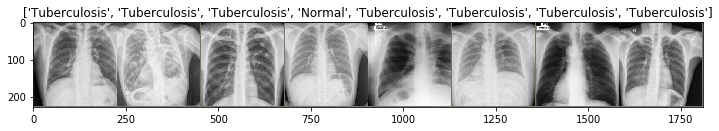

In [78]:
imshow(out, title=[class_names[x] for x in classes])

### Transfer learning
* Load the pretrained model, AlexNet and define parameters
* Set scheduler to decay Learning Rate by a factor of 0.1 every 7 epochs

In [79]:
from torchvision import models

model = models.alexnet(pretrained=True)

In [80]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [81]:
num_ftrs = model.classifier[6].in_features
num_ftrs

4096

In [82]:
model.classifier[6] = nn.Linear(num_ftrs, 2)

In [83]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [84]:
criterion   = nn.CrossEntropyLoss()

optimizer   = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [100]:
def train_model(model, criterion, optimizer, num_epochs=25):

    model = model.to(device)
    total_step = len(dataloaders['train'])


    for epoch in range(num_epochs):
        print('epoch=',epoch)        

        for i, (images,labels)  in enumerate((dataloaders['train'])):

                images = images.to(device)
                labels = labels.to(device)
    
                outputs = model(images)
                outputs = outputs.to(device)
                loss = criterion(outputs,labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        print('Epoch - %d, loss - %0.5f '\
            %(epoch, loss.item()))

    return model

In [101]:
model = train_model(model, criterion, optimizer, num_epochs=10)

epoch= 0
Epoch - 0, loss - 0.32637 
epoch= 1
Epoch - 1, loss - 0.38842 
epoch= 2
Epoch - 2, loss - 0.28161 
epoch= 3
Epoch - 3, loss - 0.31034 
epoch= 4
Epoch - 4, loss - 0.41112 
epoch= 5
Epoch - 5, loss - 0.34827 
epoch= 6
Epoch - 6, loss - 0.30162 
epoch= 7
Epoch - 7, loss - 0.17735 
epoch= 8
Epoch - 8, loss - 0.27928 
epoch= 9
Epoch - 9, loss - 0.61411 


### Model Evaluation

In [102]:
model.eval() 

with torch.no_grad():
    
    correct = 0
    total = 0
    
    for images, labels in dataloaders['test']:
        
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {}%'\
          .format(100 * correct / total))


Accuracy of the model on the test images: 84.58333333333333%


Acutal label 1


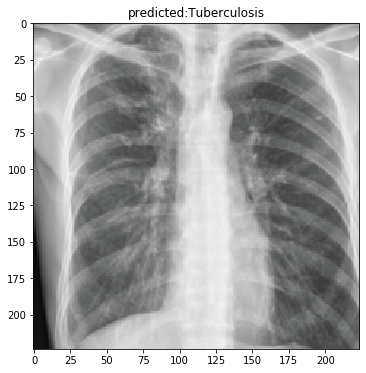

Acutal label 0


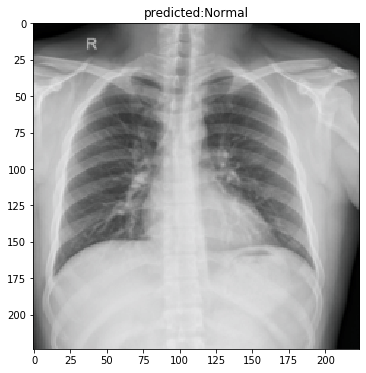

Acutal label 0


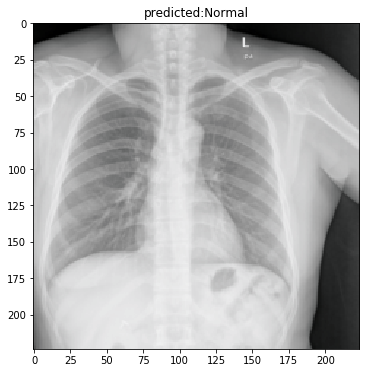

Acutal label 0


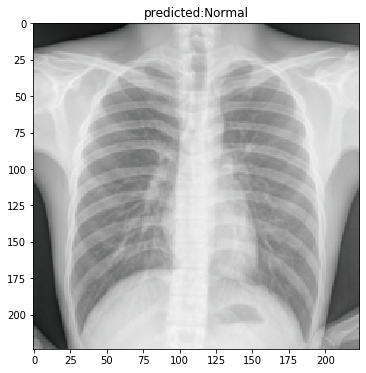

Acutal label 1


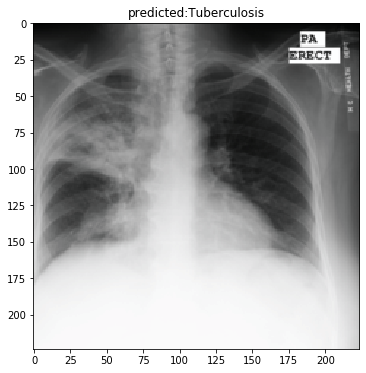

Acutal label 1


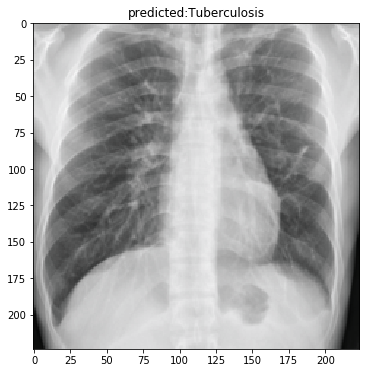

Acutal label 1


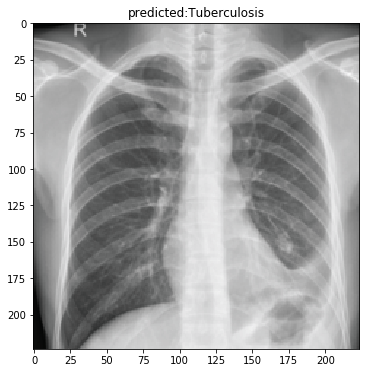

Acutal label 1


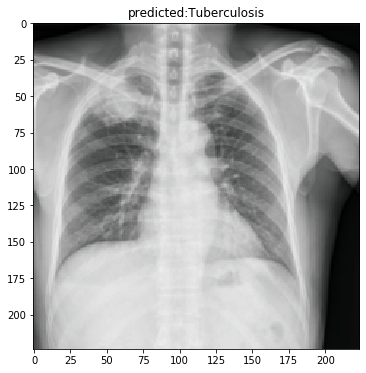

In [105]:
with torch.no_grad():
    
    inputs, labels = iter(dataloaders['test']).next()
    
    inputs = inputs.to(device)
    inp = torchvision.utils.make_grid(inputs)
    
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    
    for j in range(len(inputs)):
        print ("Acutal label", np.array(labels)[j])
        
        inp = inputs.data[j]
        imshow(inp, 'predicted:' + class_names[preds[j]])